In [296]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc_file_defaults
import numpy as np
import seaborn as sns
from collections import defaultdict
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import time
import datetime
import sys

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample
from sklearn.metrics import r2_score
from imblearn.under_sampling import RandomUnderSampler
from rfpimp import permutation_importances
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from yellowbrick.classifier import ROCAUC

# Data Collection

In [ ]:
# The following code was used to expand the Kaggle dataset
# Please note: this code will NOT work on the dataset provided, as the new dataset was made using this
# As a result, it works only on the old dataset
# Running this code should NOT work at the time of submission, as it expects the old dataset to be present
# However, for proof of its validity, please feel free to insepct the dataset provided

def getListSubset(lst, size):
    res = []
    while len(lst) >= size:
        res.append(lst[:size])
        lst = lst[size:]
    
    if list(lst):
        res.append(lst)

    return res

client_credentials_manager = SpotifyClientCredentials(client_id='a249c21a76f8493b8408422fc2cee960', client_secret='ff0a76b9281f4b92859f32f3d919ce45')
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

files = os.listdir('data')

names = {}
for f in files:
    if '.csv' in f:
        idx = f.index('.csv')
        names[f] = f[idx - 3:idx] + '-test.csv'


        
for name in names:
    df = pd.read_csv('data/' + name)
    popularity = []
    genres = []
    uris = getListSubset(df['uri'], 30)
    print(f'Making call for {name}...')
    l = len(uris)
    for i, uri in enumerate(uris):
        tracks = sp.tracks(list(uri))
        print('Done!')
        print('Updating info...')
        p = [track['popularity'] for track in tracks]
        g = [sp.artist(track["artists"][0]["external_urls"]["spotify"])['genres'] for track in tracks]
        popularity += p
        popularity += g
        print(f'Finished subsection {i + 1} of {l}')
        time.sleep(5)

    df['popularity'] = popularity
    df['genres'] = genres

    df.to_csv(names[name])
    print(f'Dataframe saved as {names[name]}')

# EDA

In [317]:
# Re-read each csv file as a dataframe, store each dataframe name in dfs
dfs = []
for year in ['2000', '2010', '1960', '1970', '1980', '1990']:
    exec('df_' + year + ' = pd.read_csv("data/" + year[-2:] + "s-test.csv")')
    exec('dfs.append("df_' + year + '")')

df_2010['year'] = 2010
df_2000['year'] = 2000
df_1990['year'] = 1990
df_1980['year'] = 1980
df_1970['year'] = 1970
df_1960['year'] = 19604

main_df = pd.concat([df_2010, df_2000, df_1990, df_1980, df_1970, df_1960])

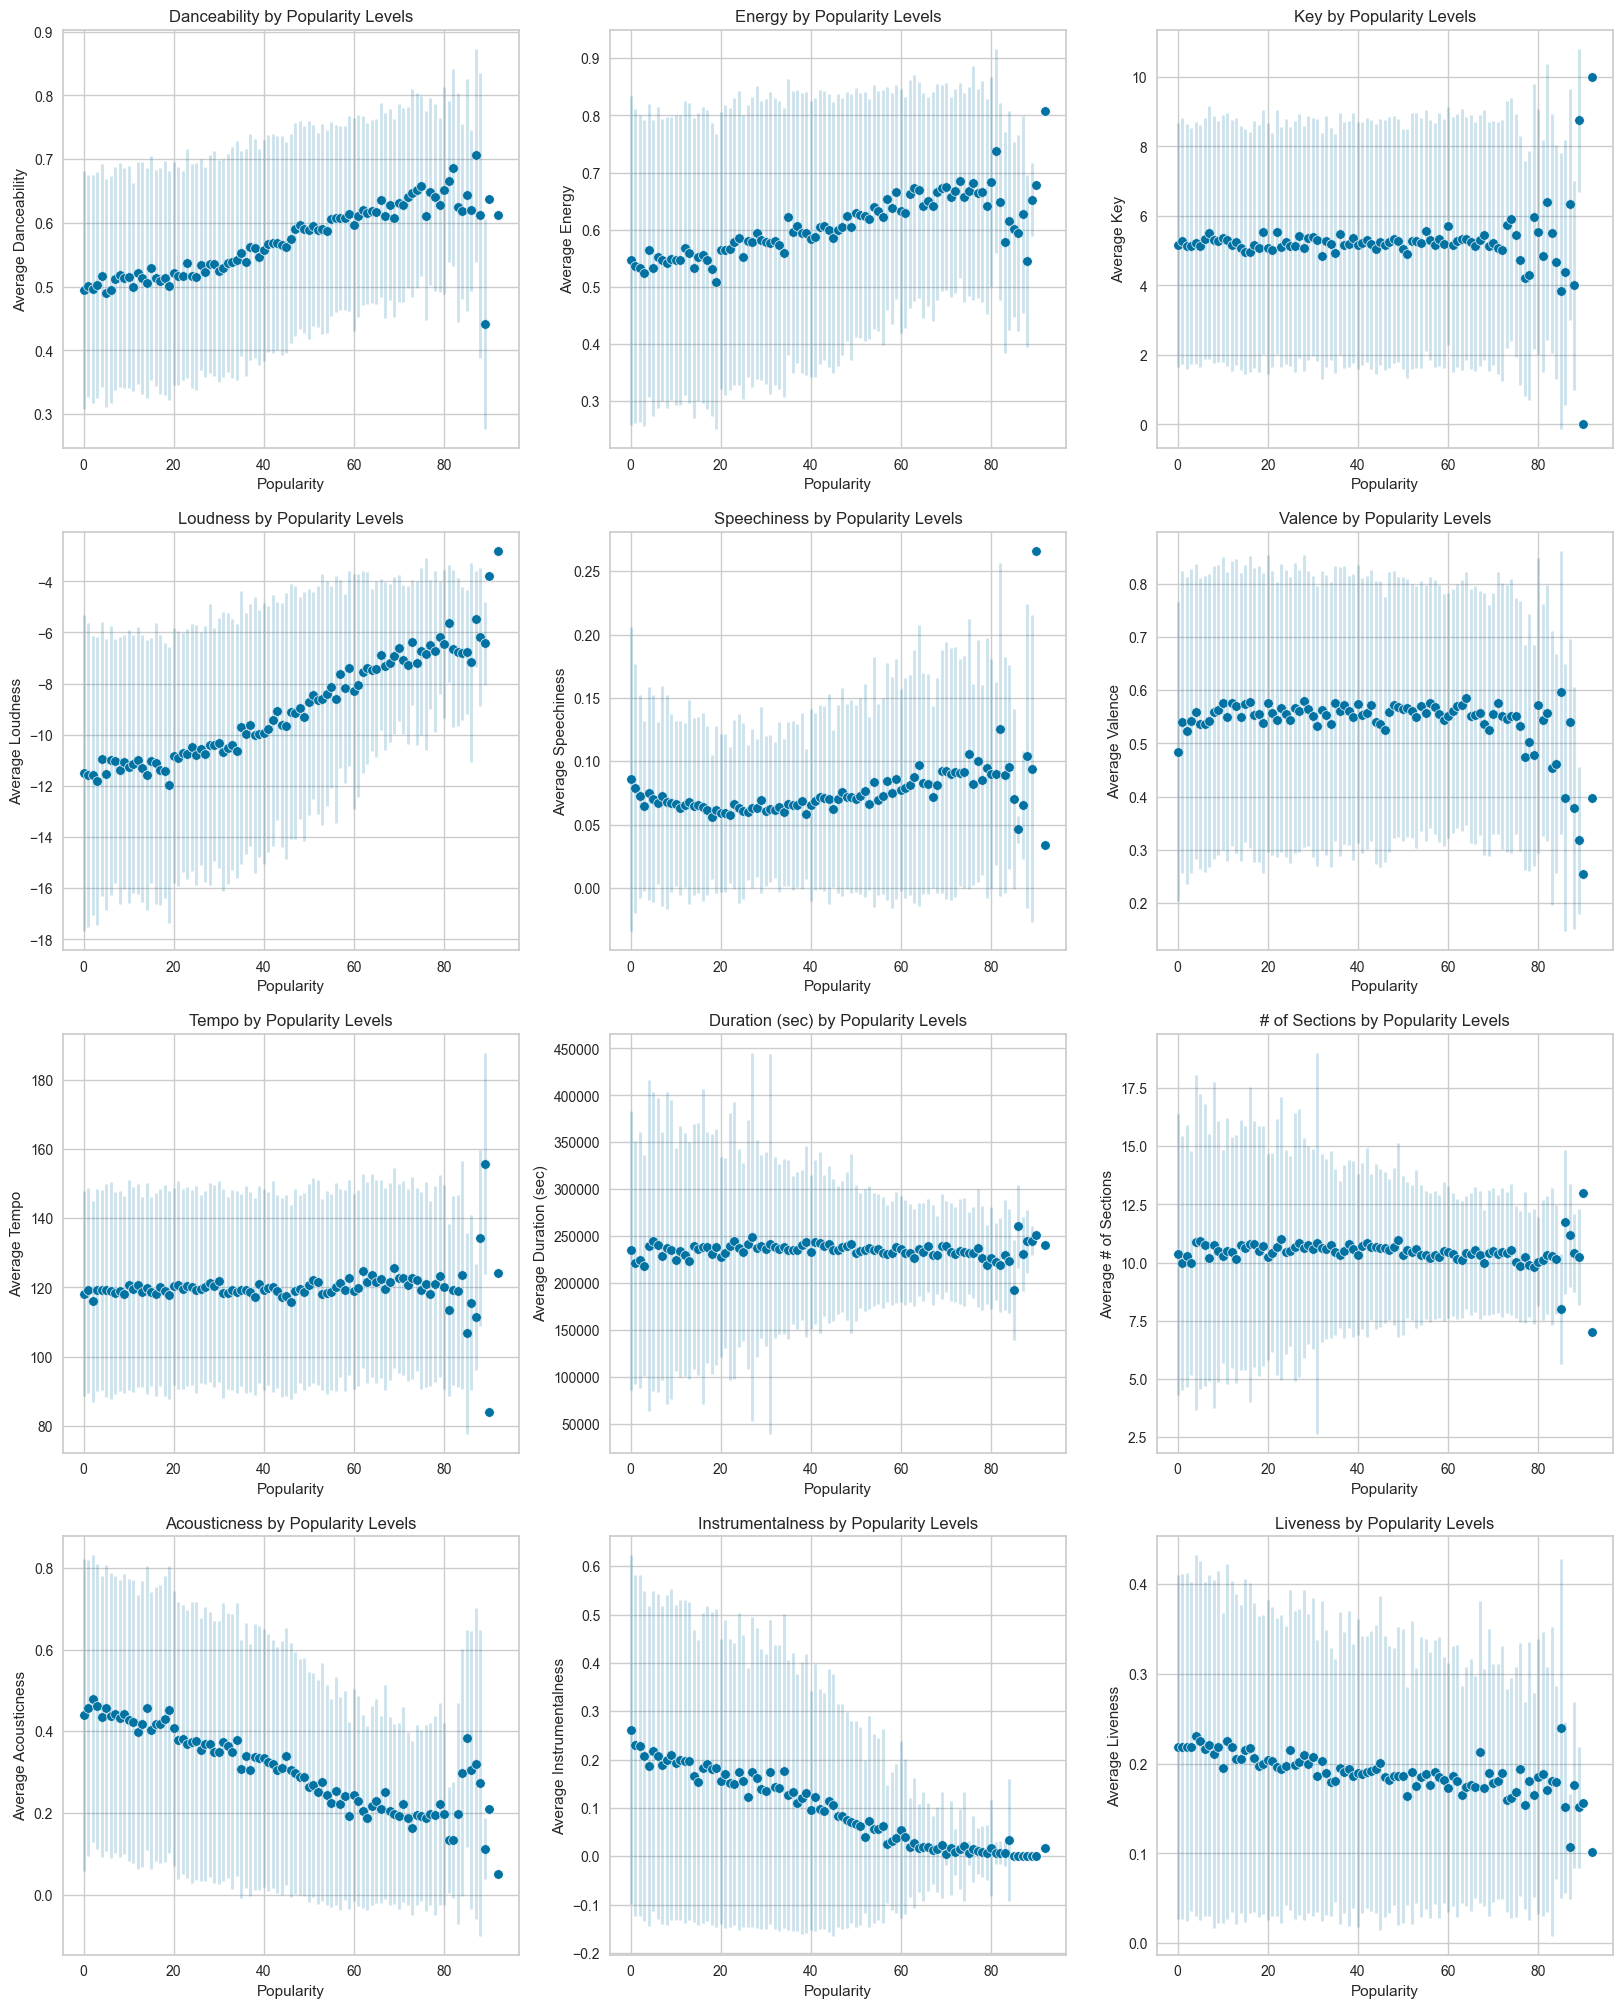

In [318]:
#Creating EDA Scatterplots

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20,25))
axes = axes.ravel()


#Boxplots
scatter_list = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'valence', 'tempo', 'duration_ms', 'sections', 'acousticness', 'instrumentalness', 'liveness' ]
graph_names = ['Danceability', 'Energy', 'Key', 'Loudness', 'Speechiness', 'Valence', 'Tempo', 'Duration (sec)', '# of Sections', 'Acousticness', 'Instrumentalness', 'Liveness' ]
scatter_length = range(12)

for var, i in zip(scatter_list, scatter_length):
    df_test = pd.DataFrame()
    df_test = main_df[['popularity', var]].copy()
    means = df_test.groupby(["popularity"])[var].mean()
    stds = df_test.groupby(["popularity"])[var].std()
    indexes = means.index
    df_graph = pd.DataFrame({'Mean':means, "Std": stds, "Index": indexes})
    
    sns.scatterplot(ax = axes[i], x='Index', y='Mean', data=df_graph);
    axes[i].errorbar(x = 'Index', y = 'Mean', yerr='Std', data=df_graph, ls='', lw=2, alpha=0.2);
    axes[i].set_title(f'{graph_names[i]} by Popularity Levels')
    axes[i].set_ylabel(f'Average {graph_names[i]}')
    axes[i].set_xlabel('Popularity')
    
plt.savefig("EDA_matrix.png")
    

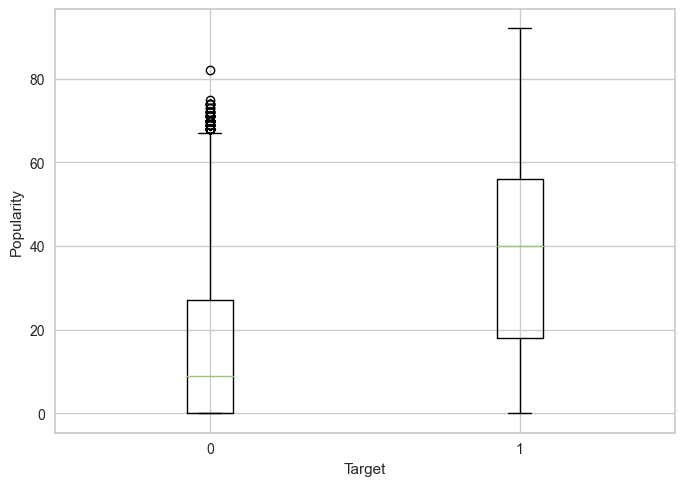

In [319]:
#Creating EDA Boxplots

fig, ax = plt.subplots()

target_data = list([main_df[main_df['target'] == 0]['popularity'], main_df[main_df['target'] == 1]['popularity']])

ax.boxplot(target_data)


# title and axis labels
ax.set_xlabel('Target')
ax.set_ylabel('Popularity')
xticklabels=['0', '1']
ax.set_xticklabels(xticklabels)


# add horizontal grid lines
ax.yaxis.grid(True)


# show the plot
plt.savefig("target.png")

# Quant Modeling

In [320]:
# Re-read each csv file as a dataframe, store each dataframe name in dfs
dfs = []
for year in ['2000', '2010', '1960', '1970', '1980', '1990']:
    exec('df_' + year + ' = pd.read_csv("data/" + year[-2:] + "s-test.csv")')
    exec('dfs.append("df_' + year + '")')

df_2010['year'] = 2010
df_2000['year'] = 2000
df_1990['year'] = 1990
df_1980['year'] = 1980
df_1970['year'] = 1970
df_1960['year'] = 19604

main_df = pd.concat([df_2010, df_2000, df_1990, df_1980, df_1970, df_1960])

In [321]:
# Checking for Dupilicates & Finding Number of Artists/Songs by Decade
no_dups = main_df.groupby(['track', 'artist']).head(1)
no_dups.shape

unique_artists = main_df.groupby(['artist']).head(1)

no_dups.groupby(["year"]).count()

unique_artists.shape

(11904, 23)

In [322]:
#Creating Forward Selection Model

col_list = main_df.columns[4:-4]
df_quant = main_df[main_df.columns[4:-4]]

mse_final = []
var_list_final = []
var_index_final = []
models = []

for s in range(len(col_list)):
  print(s)
  mse_temp = []
  for i in range(len(col_list)):
    if len(var_index_final) == 0:
      x = pd.DataFrame(df_quant[df_quant.columns[i]])
      y = main_df['popularity']

    else:
      if i not in var_index_final:
        x = pd.DataFrame(df_quant[df_quant.columns[i]])
      
        for d in range(len(var_index_final)):
          x[var_list_final[d]] = df_quant[df_quant.columns[var_index_final[d]]]
          # x = x.append(pd.DataFrame(df_quant[df_quant.columns[var_index_final[d]]]))
      else:
        pass
      y = main_df['popularity']

    x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=0)
    lreg = LinearRegression()
    lreg.fit(x_train,y_train)
    y_pred = lreg.predict(x_test)
    MSE = mean_squared_error(y_test,y_pred)
    mse_temp.append(MSE)

  var_list_final.append(col_list[(mse_temp.index(min(mse_temp)))])
  print(var_list_final)
  mse_final.append(min(mse_temp))
  var_index_final.append(mse_temp.index(min(mse_temp)))
  models.append(list(var_list_final))



0
['loudness']
1
['loudness', 'instrumentalness']
2
['loudness', 'instrumentalness', 'danceability']
3
['loudness', 'instrumentalness', 'danceability', 'valence']
4
['loudness', 'instrumentalness', 'danceability', 'valence', 'acousticness']
5
['loudness', 'instrumentalness', 'danceability', 'valence', 'acousticness', 'energy']
6
['loudness', 'instrumentalness', 'danceability', 'valence', 'acousticness', 'energy', 'liveness']
7
['loudness', 'instrumentalness', 'danceability', 'valence', 'acousticness', 'energy', 'liveness', 'duration_ms']
8
['loudness', 'instrumentalness', 'danceability', 'valence', 'acousticness', 'energy', 'liveness', 'duration_ms', 'speechiness']
9
['loudness', 'instrumentalness', 'danceability', 'valence', 'acousticness', 'energy', 'liveness', 'duration_ms', 'speechiness', 'tempo']
10
['loudness', 'instrumentalness', 'danceability', 'valence', 'acousticness', 'energy', 'liveness', 'duration_ms', 'speechiness', 'tempo', 'time_signature']
11
['loudness', 'instrumental

In [323]:
#Exporting Forward Selection to CSV

forward_models = pd.DataFrame()
forward_models['Variables'] = models
forward_models['MSE'] = mse_final
forward_models.head()

forward_models.to_csv('forward_models.csv', index=False)


In [324]:
#Lasso Regression Model - Hyperparameter Tuning

x = preprocessing.scale(df_quant)

y = main_df['popularity']

x_train, x_test, y_train, y_test = train_test_split(x,y,train_size=0.8,random_state=0)


alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
lassoCV_val_mses_mean = []

# define model
model = LassoCV(alphas=alphas, fit_intercept = False, max_iter=100000)
model.fit(x_train, y_train)

for value in model.mse_path_:
    lassoCV_val_mses_mean.append(np.mean(value))
    
best_alpha = model.alpha_
print("Best Alpha", best_alpha)

NameError: name 'preprocessing' is not defined

In [ ]:
#Running the Lasso Regression with the Best Alpha
# Set bootstrapping parameters
numboot = 100
fit_intercept = True

# Create empty dictionary for storing results
significant_degrees = {}

# Perform bootstraps
for i in range(numboot):
    df_boot_main = main_df.sample(frac=1, replace=True)
    x_train_boot =  preprocessing.scale(main_df[main_df.columns[4:-4]])
    y_train_boot = df_boot_main.popularity

    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=100000,
        alpha=best_alpha,
    )
    lasso.fit(x_train_boot, y_train_boot)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1


In [ ]:
#Graphing Results of Bootstrapped Lasso Regression Model

sig_vars = pd.DataFrame.from_dict(significant_degrees, orient='index').sort_index()
values_list = list(sig_vars[[0]][0].values)[1:]
arr = np.array(values_list)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(10,5))

var_list = list(df_quant.columns)
y_pos = np.arange(len(var_list))

ax.set_title("Number of times each degree coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,)
ax.set_xlabel('Income')
ax.barh(var_list, arr);


In [ ]:
# Read each csv file as a dataframe, store each dataframe name in dfs
dfs = []
for year in ['2000', '2010', '1960', '1970', '1980', '1990']:
    exec('df_' + year + ' = pd.read_csv("data/" + year[-2:] + "s-test.csv")')
    exec('dfs.append("df_' + year + '")')

# Category Modeling

In [233]:
# Drop the 2nd index column, target, and uri columns from each dataframe; drop all non-float
for df in dfs:
    exec(df + ".drop(['Unnamed: 0', 'track', 'artist', 'target', 'uri', 'genres'], axis = 1, inplace=True)")

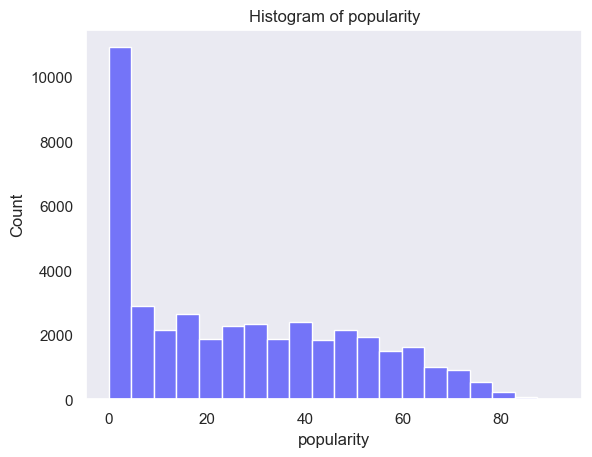

In [235]:
# test the distribution of popularity
full_df = pd.concat([df_2010, df_2000, df_1990, df_1980, df_1970, df_1960])
pop = full_df['popularity']
sns.set()
sns.histplot(pop, alpha=0.5, color='blue', bins=20)
plt.grid()
plt.title('Histogram of popularity')
plt.savefig('PopDist.png', bbox_inches = 'tight', dpi=800)
plt.show()

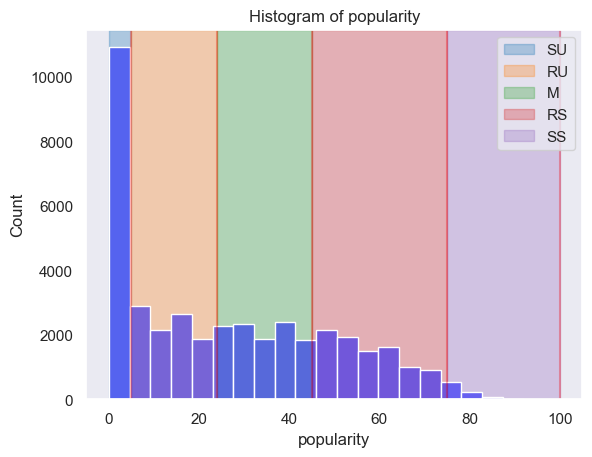

In [262]:
# split popularity into 5 sections:
# significantly unpopular, relatively unpopular, medium, relatively popular, significantly popular
# our first is 0 to 5, as this is the most common
# 75 and above is significant
# we then split the rest as uniform

# get split for 
qranges = np.quantile([p for p in pop if p > 5 and p < 75], [1/3, 2/3], method='normal_unbiased')

sns.set()

for i, q in enumerate(qranges):
    plt.axvline(q, color='red', alpha=0.3)

plt.axvline(5, color='red', alpha=0.3)
plt.axvline(75, color='red', alpha=0.3)
plt.axvline(100, color='red', alpha=0.3)

# color between
plt.axvspan(0, 5, alpha=0.3, color='#1f77b4', label='SU')
plt.axvspan(5, qranges[0], alpha=0.3, color='#ff7f0e', label='RU')
plt.axvspan(qranges[0], qranges[1], alpha=0.3, color='#2ca02c', label='M')
plt.axvspan(qranges[1], 75, alpha=0.3, color='#d62728', label='RS')
plt.axvspan(75, 100, alpha=0.3, color='#9467bd', label='SS')

sns.histplot(pop, alpha=0.5, color='blue', bins=20)
plt.grid()
plt.title('Histogram of popularity')
plt.legend()
plt.savefig('UniformBoundaries.png', bbox_inches = 'tight', dpi=800)
plt.show()

In [237]:
# using the data from before, we can create a function to assign categorical variables
# to the popularity index using:
'''
0 --> Significantly unpopular
1 --> Relatively unpopular
2 --> Moderate
3 --> Relatively popular
4 --> Significantly popular
'''

# takes in array of popularities
def assignPopularity(arr):
    res = []
    for pop in arr:
        if pop <= 5:
            res.append(0)
        elif pop <= qranges[0]:
            res.append(1)
        elif pop <= qranges[1]:
            res.append(2)
        elif pop <= 75:
            res.append(3)
        else:
            res.append(4)

    return res

In [238]:
# using the function from before, assign the values to the dataframe
full_df['pop_cat'] = assignPopularity(full_df['popularity'])
full_df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,popularity,pop_cat
0,0.741,0.626,1,-4.826,0,0.0886,0.02000,0.000,0.0828,0.706,108.029,188493,4,41.18681,10,2,0
1,0.447,0.247,5,-14.661,0,0.0346,0.87100,0.814,0.0946,0.250,155.489,176880,3,33.18083,9,32,2
2,0.550,0.415,9,-6.557,0,0.0520,0.16100,0.000,0.1080,0.274,172.065,205463,4,44.89147,9,65,3
3,0.502,0.648,0,-5.698,0,0.0527,0.00513,0.000,0.2040,0.291,91.837,193043,4,29.52521,7,45,2
4,0.807,0.887,1,-3.892,1,0.2750,0.00381,0.000,0.3910,0.780,160.517,144244,4,24.99199,8,59,3


In [239]:
# split data
X = full_df.drop(['popularity', 'pop_cat'], axis=1)
y = full_df['pop_cat']

# standardize data
s = StandardScaler()

to_be_scaled = ['tempo', 'duration_ms', 'chorus_hit']
X[to_be_scaled] = s.fit_transform(full_df[to_be_scaled])


# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [240]:
# start with adaboostclassifier
estimators = defaultdict(lambda : {'model' : None, 'score' : -1})

# we are gonna do cv on the depth and the learning rate
# for each, we will store them in an estimators dictionary for later use

depths = [1, 2, 3, 4, 5]
learning_rates = [0.0001, 0.001, 0.01, 0.05, 0.1]
num_est = 800

cv_splits = 5

# go through each combination
for depth in depths:
    for lr in learning_rates:
        # create classifier
        ada_class = AdaBoostClassifier(DecisionTreeClassifier(max_depth=depth), n_estimators=num_est, learning_rate=lr)

        # fit classifier
        ada_class.fit(X_train, y_train)

        # call cv
        cv_score = cross_val_score(ada_class, X_train, y_train, scoring='accuracy', cv=cv_splits)

        # add information to the dictionary
        estimators[(depth, lr)]['model'] = ada_class
        estimators[(depth, lr)]['score'] = np.mean(cv_score)

        print(f'Finished depth {depth} at learning rate {lr}')

e_copy = estimators.copy()


Finished depth 1 at learning rate 0.0001
Finished depth 1 at learning rate 0.001
Finished depth 1 at learning rate 0.01
Finished depth 1 at learning rate 0.05
Finished depth 1 at learning rate 0.1
Finished depth 2 at learning rate 0.0001
Finished depth 2 at learning rate 0.001
Finished depth 2 at learning rate 0.01
Finished depth 2 at learning rate 0.05
Finished depth 2 at learning rate 0.1
Finished depth 3 at learning rate 0.0001
Finished depth 3 at learning rate 0.001
Finished depth 3 at learning rate 0.01
Finished depth 3 at learning rate 0.05
Finished depth 3 at learning rate 0.1
Finished depth 4 at learning rate 0.0001
Finished depth 4 at learning rate 0.001
Finished depth 4 at learning rate 0.01
Finished depth 4 at learning rate 0.05
Finished depth 4 at learning rate 0.1
Finished depth 5 at learning rate 0.0001
Finished depth 5 at learning rate 0.001
Finished depth 5 at learning rate 0.01
Finished depth 5 at learning rate 0.05
Finished depth 5 at learning rate 0.1


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X 

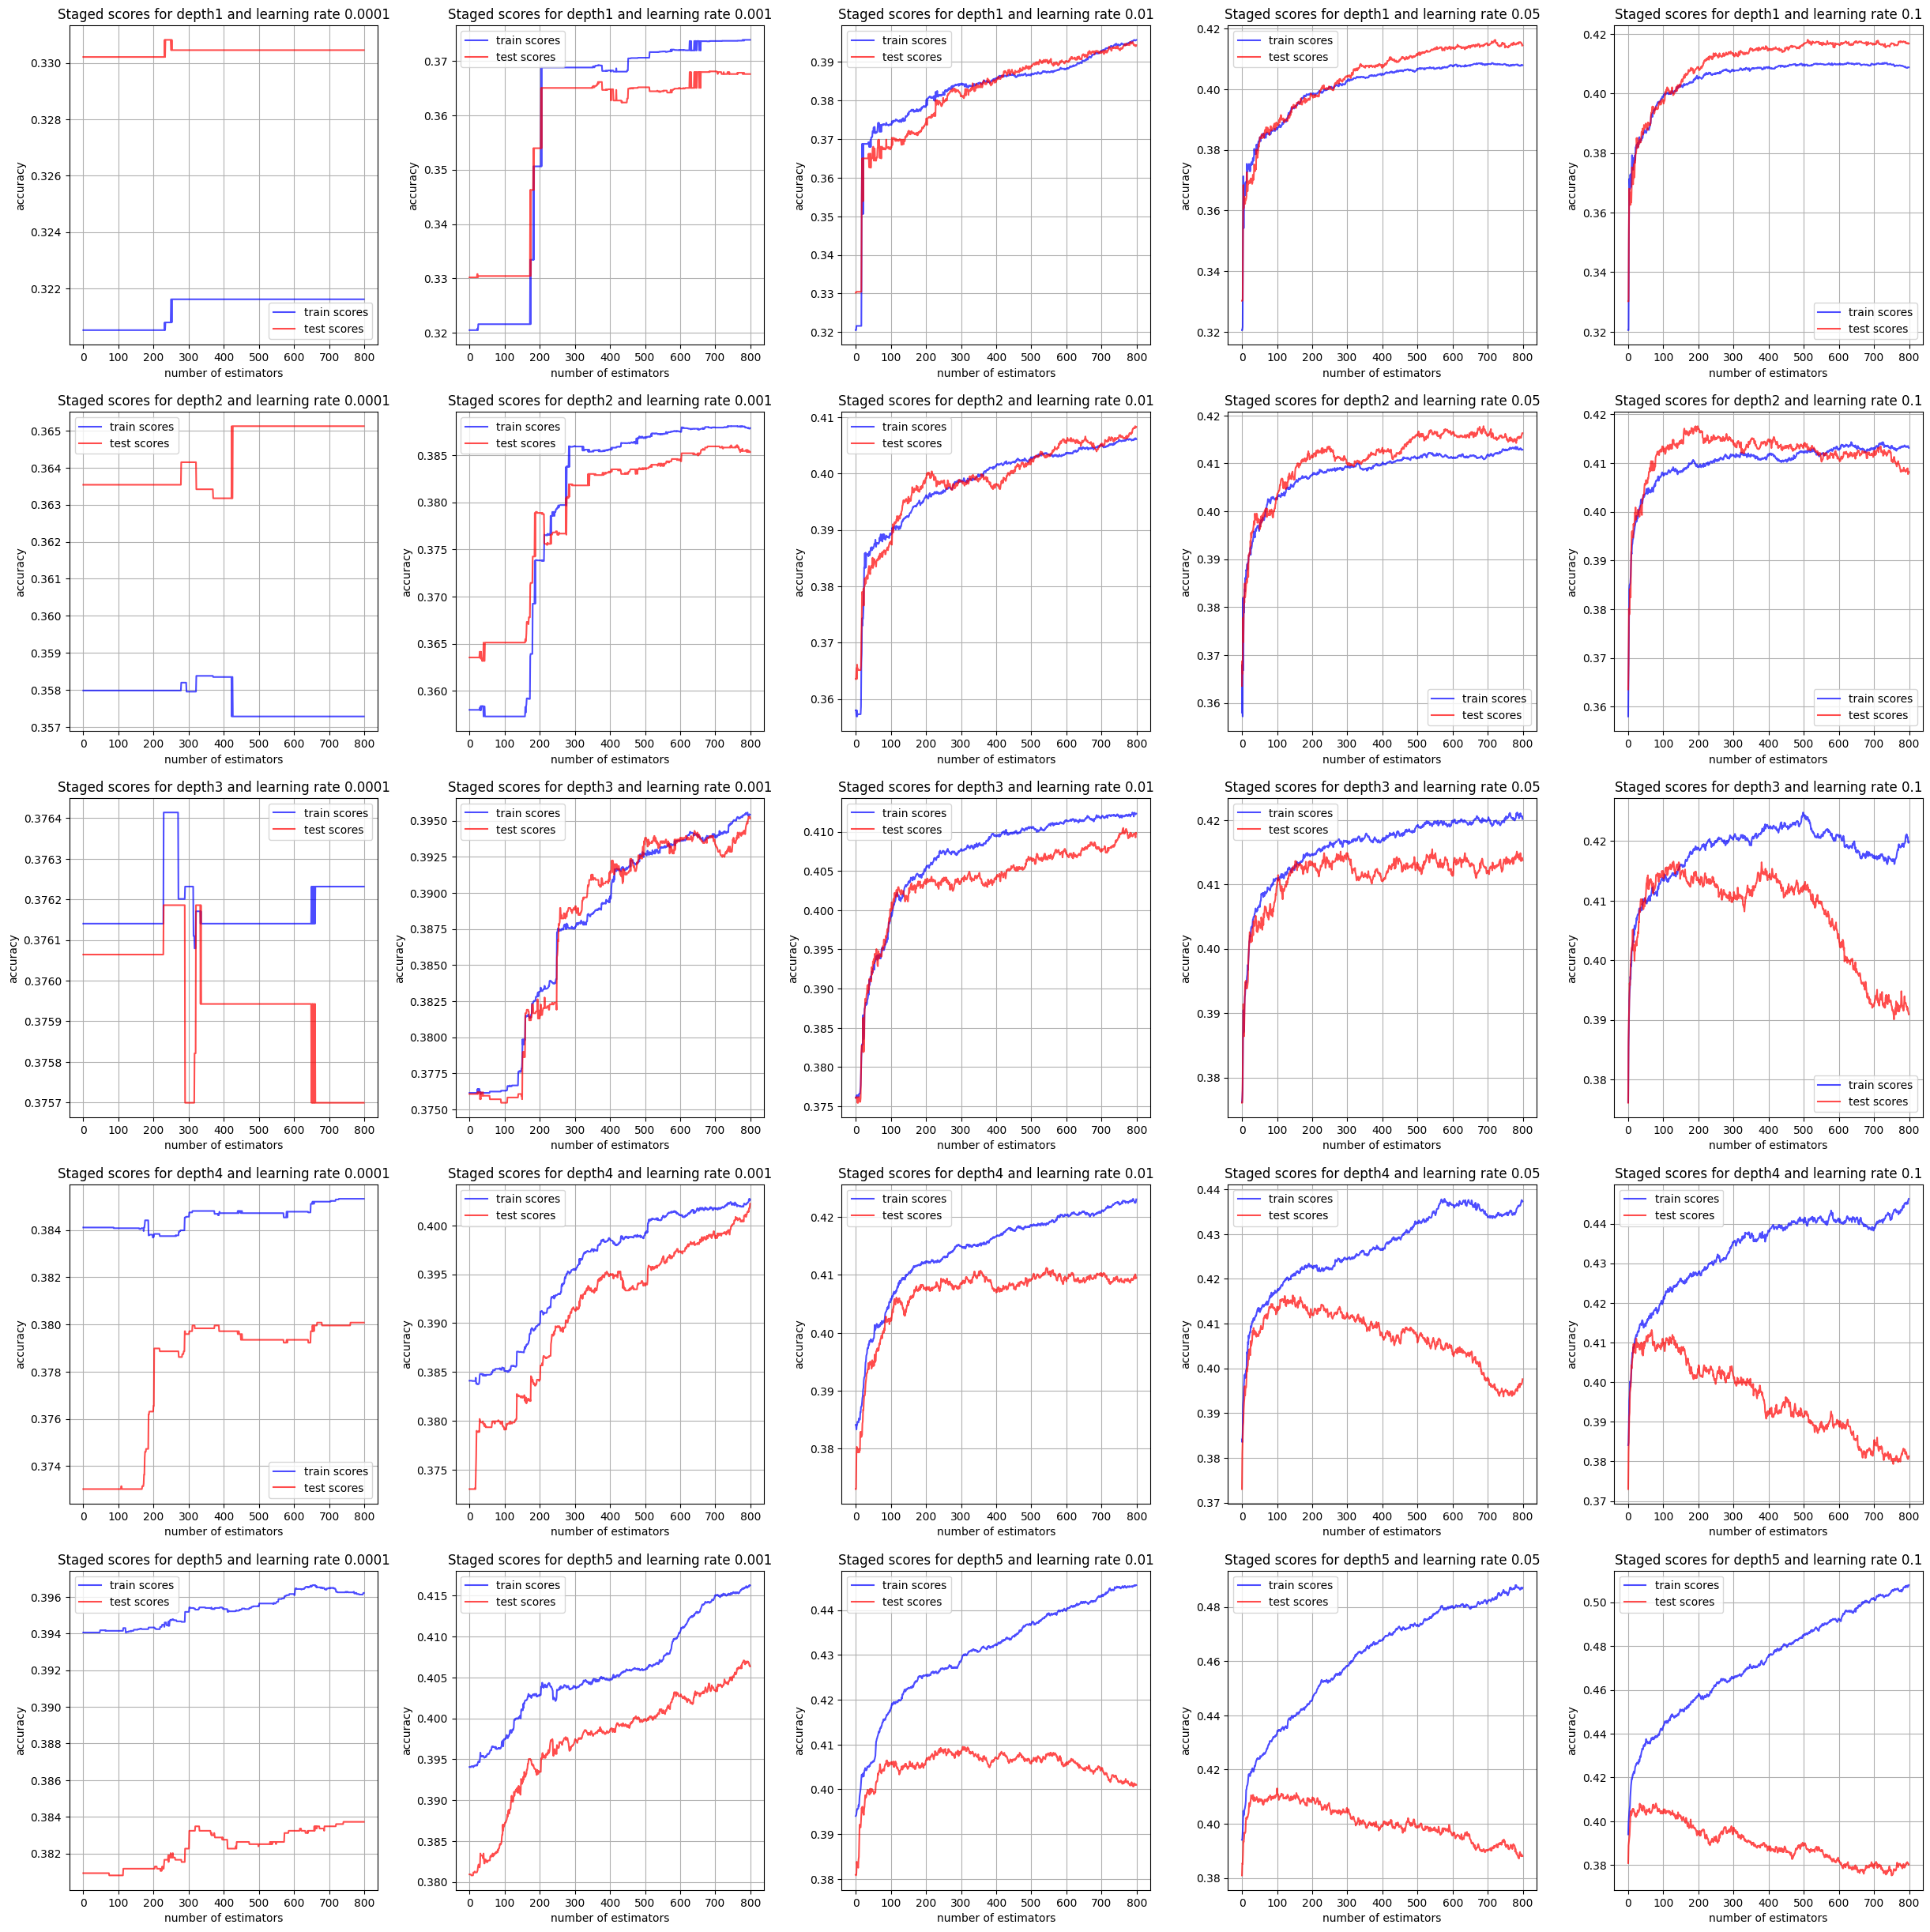

In [245]:
# create staged scores for each model

fig, ax = plt.subplots(5,5)
fig.set_size_inches(25, 25)
plt.tight_layout(pad=4.0)
rc_file_defaults()
# go through each combination
for i, depth in enumerate(depths):
    for j, lr in enumerate(learning_rates):
        # get staged score
        ss_train = list(estimators[(depth, lr)]['model'].staged_score(X_train, y_train))
        ss_test = list(estimators[(depth, lr)]['model'].staged_score(X_test, y_test))

        ax[i][j].plot(list(range(len(ss_train))), ss_train, color='blue', label='train scores', alpha=0.7)
        ax[i][j].plot(list(range(len(ss_test))), ss_test, color='red', label='test scores', alpha=0.7)

        ax[i][j].set_xlabel('number of estimators')
        ax[i][j].set_ylabel('accuracy')
        ax[i][j].set_title(f'Staged scores for depth{depth} and learning rate {lr}')
        ax[i][j].grid()
        ax[i][j].legend()

plt.savefig('test.png', bbox_inches = 'tight')
plt.show()



In [269]:
# doing a similar thing for random forest
num_ests = [100, 200, 300, 400, 500, 600]
depths_rf = [1, 10, 15, 20, 25, 30, 40]

estimators_rf = defaultdict(lambda : {'model' : None, 'score' : -1})

cv_rf = 5

for est in num_ests:
    for depth in depths_rf:
        # fit random forest combinations
        rf = RandomForestClassifier(n_estimators=est, max_depth=depth, class_weight='balanced_subsample')

        # fit the random forest
        rf.fit(X_train, y_train)

        # cross validation
        scores = cross_val_score(rf, X_train, y_train, scoring='accuracy', cv=cv_rf)

        # add information
        estimators_rf[(est, depth)]['model'] = rf
        estimators_rf[(est, depth)]['score'] = np.mean(scores)

        print(f'Finished num_est {est} and depth {depth}')


Finished num_est 100 and depth 1
Finished num_est 100 and depth 10
Finished num_est 100 and depth 15
Finished num_est 100 and depth 20
Finished num_est 100 and depth 25
Finished num_est 100 and depth 30
Finished num_est 100 and depth 40
Finished num_est 200 and depth 1
Finished num_est 200 and depth 10
Finished num_est 200 and depth 15
Finished num_est 200 and depth 20
Finished num_est 200 and depth 25
Finished num_est 200 and depth 30
Finished num_est 200 and depth 40
Finished num_est 300 and depth 1
Finished num_est 300 and depth 10
Finished num_est 300 and depth 15
Finished num_est 300 and depth 20
Finished num_est 300 and depth 25
Finished num_est 300 and depth 30
Finished num_est 300 and depth 40
Finished num_est 400 and depth 1
Finished num_est 400 and depth 10
Finished num_est 400 and depth 15
Finished num_est 400 and depth 20
Finished num_est 400 and depth 25
Finished num_est 400 and depth 30
Finished num_est 400 and depth 40
Finished num_est 500 and depth 1
Finished num_est 50

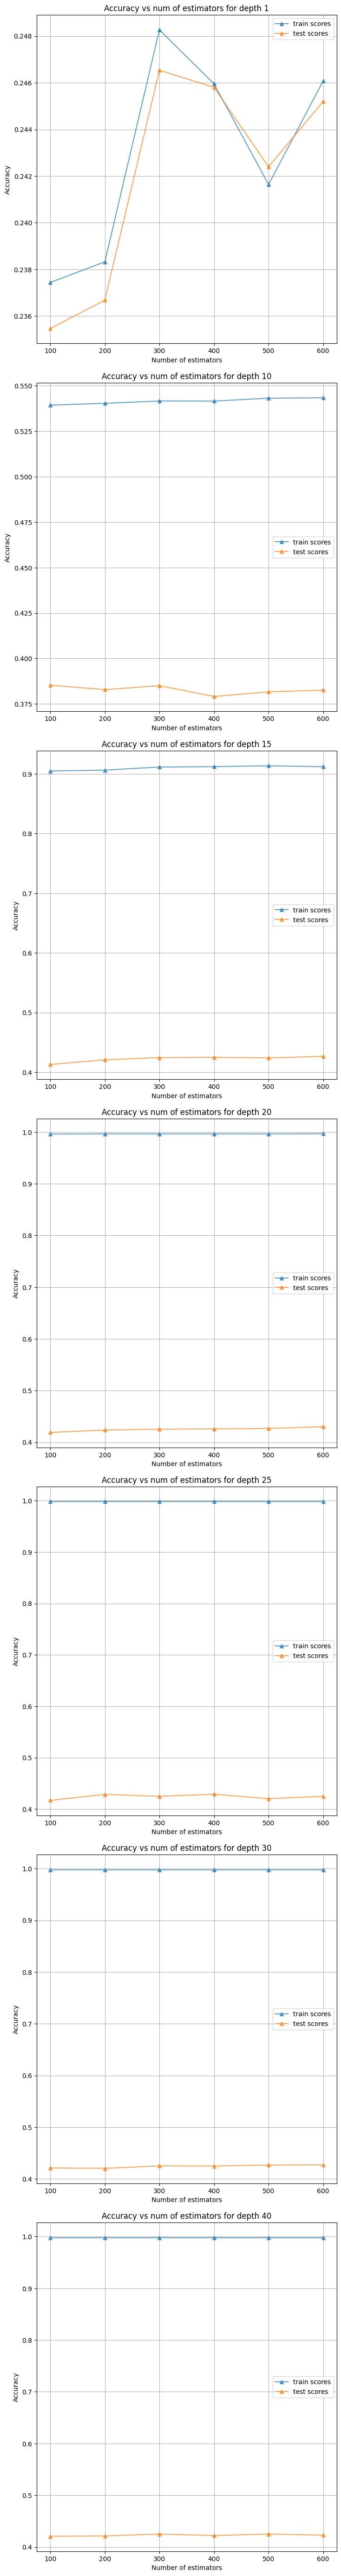

In [271]:
# plot "semi-staged" for random forest
fig, ax = plt.subplots(7,1)
fig.set_size_inches(8, 56)
plt.tight_layout(pad=4.0)
rc_file_defaults()

# create list of depth at different rates
for i, depth in enumerate(depths_rf):
    acc_train = []
    acc_test = []
    # run through each number of estimators
    for est in num_ests:
        acc_train.append(estimators_rf[(est, depth)]['model'].score(X_train, y_train))
        acc_test.append(estimators_rf[(est, depth)]['model'].score(X_test, y_test))
    
    ax[i].plot(num_ests, acc_train, label='train scores', alpha=0.7, marker='^')
    ax[i].plot(num_ests, acc_test, label='test scores', alpha=0.7, marker='^')
    ax[i].set_xlabel('Number of estimators')
    ax[i].set_ylabel('Accuracy')
    ax[i].set_title(f'Accuracy vs num of estimators for depth {depth}')
    ax[i].grid()
    ax[i].legend()

plt.savefig('test2.png', bbox_inches = 'tight', dpi=800)
plt.show()

In [272]:
# Best models

# Ada boost --> d3, lr 0.05, 290

# Random forest --> 400 estimators, 25 depth

ada_final = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators = 290, learning_rate=0.05)
ada_final.fit(X_train, y_train)
rf_final = estimators_rf[(400, 30)]['model']
# rf_final.fit(X_train, y_train)



In [273]:
print(ada_final.score(X_test, y_test))
print(rf_final.score(X_test, y_test))


def acc(rf, X_train, y_train):
    return accuracy_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(rf, X_train, y_train, acc)

0.4135246898564826
0.4248358063731452


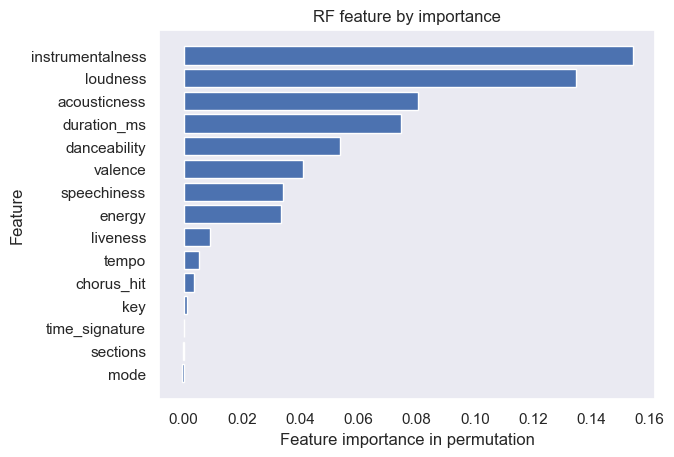

In [274]:
perm_imp_rfpimp.index
sns.set()
plt.barh(perm_imp_rfpimp.index[::-1], perm_imp_rfpimp['Importance'][::-1])
plt.grid()
plt.xlabel('Feature importance in permutation')
plt.ylabel('Feature')
plt.title('RF feature by importance')

plt.savefig('RFfeature.png', bbox_inches = 'tight', dpi=800)

In [275]:
# find p-value of accuracy


# generate random test values
# by CLT, 30 is a good approximation
null_distribution = []
for _ in range(30):
    # generate random guesses
    guesses = np.random.randint(0, 5, size=len(X_test))

    # check accuracy of them
    null_distribution.append(accuracy_score(y_test, guesses))

guess_mean = np.mean(null_distribution)
guess_sd = np.std(null_distribution)

In [276]:
# find z-score of accuracy
z = (rf_final.score(X_test, y_test) - guess_mean) / guess_sd

# find p value
1 - norm.cdf(z)

0.0

In [259]:
# get predictions
t = rf_final.predict_proba(X_test)

# get top3
t2 = [np.argsort(thing)[::-1][:2] for thing in t]

# check for correctness
correctness = sum(thing in t2[i] for i, thing in enumerate(y_test))

# check accuracy
print(correctness / len(y_test))

0.684869861347604


In [277]:
display(confusion_matrix(y_test, rf_final.predict(X_test)))

array([[1310,  425,  264,  305,    0],
       [ 714,  570,  372,  269,    0],
       [ 575,  423,  469,  499,    0],
       [ 233,  208,  349, 1136,    0],
       [   7,    2,    7,   77,    8]])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


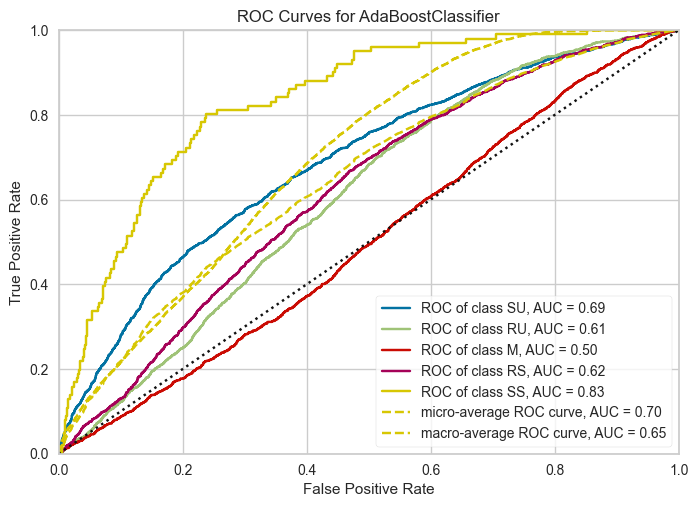

<AxesSubplot: title={'center': 'ROC Curves for AdaBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [287]:
# create one vs all for adaboost
model = ada_final
visualizer = ROCAUC(model, classes=["SU", "RU", "M", "RS", "SS"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


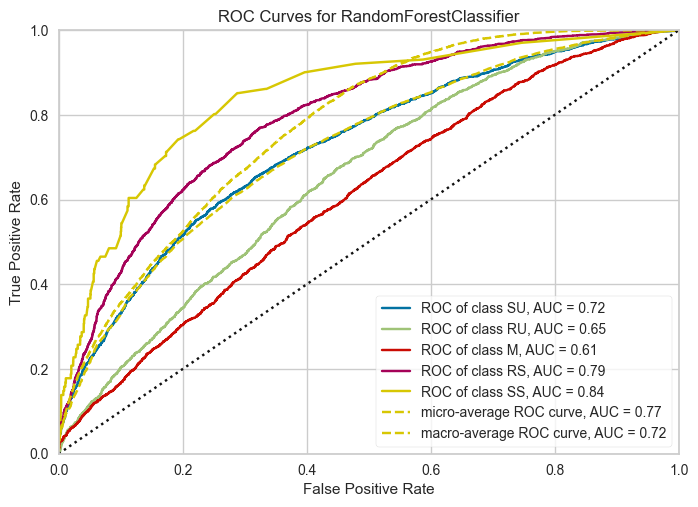

<AxesSubplot: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [286]:
# create one vs all for random forest
model = rf_final
visualizer = ROCAUC(model, classes=["SU", "RU", "M", "RS", "SS"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()


# Time Series Analysis

In [325]:
# initialize important arrays
perm_imps = []
index = [2,3,4,5,0,1]
dfs = [df[i] for i in index]
adaboost_scores = []
randomforest_scores = []

# go through each dataframe by decade
for df in dfs:
    # assign categorical
    full_df['pop_cat'] = assignPopularity(full_df['popularity'])
    X = full_df.drop(['popularity', 'pop_cat'], axis=1)
    y = full_df['pop_cat']

    # standardize data
    s = StandardScaler()

    to_be_scaled = ['tempo', 'duration_ms', 'chorus_hit']
    X[to_be_scaled] = s.fit_transform(full_df[to_be_scaled])

    # train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    ada_year = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3), n_estimators = 290, learning_rate=0.05)
    ada_year.fit(X_train, y_train)
    
    rf_year = RandomForestClassifier(n_estimators=400, max_depth=30)

    # fit the random forest
    rf_year.fit(X_train, y_train)
    
    adaboost_scores.append(ada_year.score(X_test, y_test))
    randomforest_scores.append(rf_year.score(X_test, y_test))
    
    def acc(rf_year, X_train, y_train):
        return accuracy_score(y_train, rf_year.predict(X_train))

    #compute permutation importance
    perm_imp_rfpimp = permutation_importances(rf_year, X_train, y_train, acc)
    perm_imps.append(perm_imp_rfpimp)

# compile results
results_df = pd.DataFrame()
results_df['Decade'] = ["1960s", "1970s", "1980s", "1990s", "2000s", "2010s"]
results_df['Accuracy Scores Using AdaBoost'] = [adaboost_scores[0], adaboost_scores[1], adaboost_scores[2], adaboost_scores[3], adaboost_scores[4], adaboost_scores[5]]
results_df['Accuracy Scores Using Random Forest'] = [randomforest_scores[0], randomforest_scores[1], randomforest_scores[2], randomforest_scores[3], randomforest_scores[4], randomforest_scores[5]]

In [326]:
display(results_df)

,Decade,Accuracy Scores Using AdaBoost,Accuracy Scores Using Random Forest
0,1960s,0.399538,0.416200
1,1970s,0.413160,0.425687
2,1980s,0.403065,0.422403
3,1990s,0.406227,0.425930
4,2000s,0.412552,0.434931
5,2010s,0.416687,0.425444


In [327]:
# list all features and most important
features = ['instrumentalness','loudness','acousticness','duration_ms','danceability','valence','speechiness','energy','liveness','tempo','sections','chorus_hit','key','mode','time_signature']
top_features = ['instrumentalness','loudness','acousticness','duration_ms','danceability','valence','speechiness','energy']

# initialize dictionaries
feature_dict = {}
top_features_dict = {}
for f in features:
    feature_dict[f] = []

# work through dictionary for all features
for i in range(6):
    for feature in features:
        # print(perm_imps[i]['Importance'][feature])
        feature_dict[feature].append(perm_imps[i]['Importance'][feature])

# work through dictionary for top features
for x in top_features: 
    top_features_dict[x] = []

# append importance when isolated
for y in range(6): 
    for each in top_features: 
        top_features_dict[each].append(perm_imps[y]['Importance'][each])

print(top_features_dict)

{'instrumentalness': [0.21099999999999997, 0.21299999999999997, 0.20020000000000004, 0.2026, 0.2138, 0.18420000000000003], 'loudness': [0.14800000000000002, 0.13880000000000003, 0.14160000000000006, 0.15280000000000005, 0.15580000000000005, 0.15660000000000007], 'acousticness': [0.11499999999999999, 0.12119999999999997, 0.12440000000000007, 0.11020000000000008, 0.10699999999999998, 0.11860000000000004], 'duration_ms': [0.11199999999999999, 0.10219999999999996, 0.11580000000000001, 0.10320000000000007, 0.11380000000000001, 0.10440000000000005], 'danceability': [0.07740000000000002, 0.0706, 0.07840000000000003, 0.0726, 0.06579999999999997, 0.07220000000000004], 'valence': [0.04480000000000006, 0.03959999999999997, 0.052000000000000046, 0.04920000000000002, 0.048799999999999955, 0.04180000000000006], 'speechiness': [0.04159999999999997, 0.041200000000000014, 0.04039999999999999, 0.03380000000000005, 0.04259999999999997, 0.04360000000000008], 'energy': [0.03700000000000003, 0.0383999999999

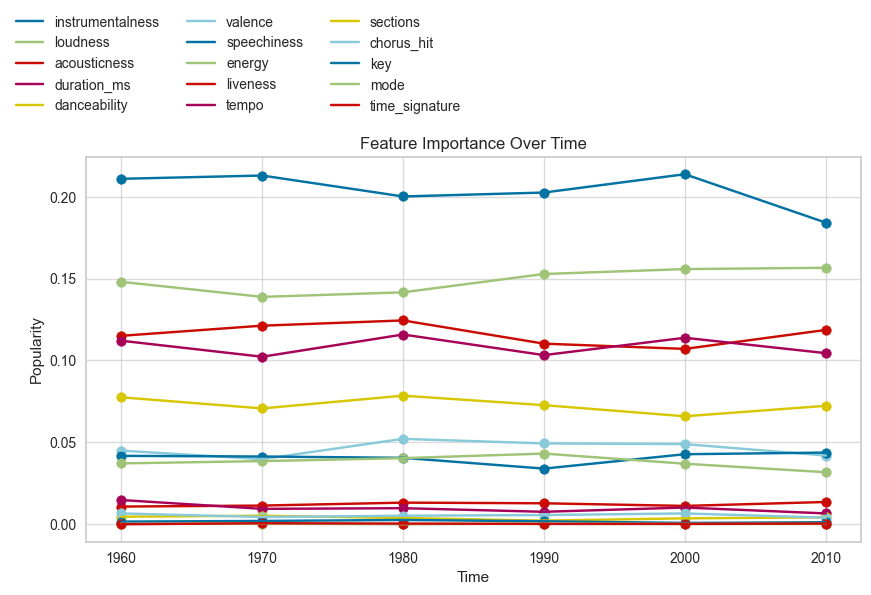

In [328]:
# initialize some important data for graphing, going through feature importance over time
keys = feature_dict.keys()
keys = list(keys)
decades = ['Decade of 2000s', 'Decade of 2010s', 'Decade of 1960s', 'Decade of 1970s', 'Decade of 1980s', 'Decade of 1990s']

j = 0 

years = range(1960,2011,10)

plt.figure(figsize=(10,5))

# plot prediction-importance over time
for i in feature_dict:
    plt.plot(years, feature_dict[i], label = keys[j])
    plt.scatter(years, feature_dict[i])
    plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1.4),
          ncol=3, fancybox=True, shadow=True)
    plt.xlabel('Time')
    plt.ylabel('Popularity')
    plt.title(f'Feature Importance Over Time')
    plt.grid(":", alpha=0.7)
    j+=1
    plt.savefig('RFfeature.png', bbox_inches = 'tight', dpi=800)
plt.show()

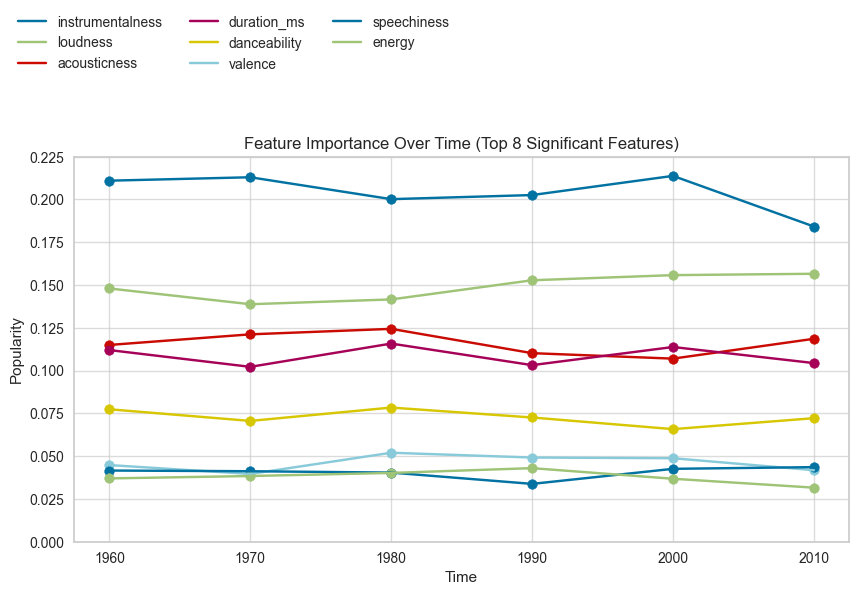

In [329]:
# now do the same thing but for top features
decades = ['Decade of 2000s', 'Decade of 2010s', 'Decade of 1960s', 'Decade of 1970s', 'Decade of 1980s', 'Decade of 1990s']

j = 0 

years = range(1960,2011,10)

plt.figure(figsize=(10,5))

for i in top_features_dict:
    plt.plot(years, top_features_dict[i], label = keys[j])
    plt.scatter(years, top_features_dict[i])
    plt.legend(loc='upper right', bbox_to_anchor=(0.5, 1.4),
          ncol=3, fancybox=True, shadow=True)
    plt.ylim(0,0.225)
    plt.xlabel('Time')
    plt.ylabel('Popularity')
    plt.title(f'Feature Importance Over Time (Top 8 Significant Features)')
    plt.grid(":", alpha=0.7)
    j+=1
    plt.savefig('RFfeature.png', bbox_inches = 'tight', dpi=800)
plt.show()

# Genre Analysis

In [288]:
# Re-read each csv file as a dataframe, store each dataframe name in dfs
dfs = []
for year in ['2000', '2010', '1960', '1970', '1980', '1990']:
    exec('df_' + year + ' = pd.read_csv("data/" + year[-2:] + "s-test.csv")')
    exec('dfs.append("df_' + year + '")')

df_2010['year'] = 2010
df_2000['year'] = 2000
df_1990['year'] = 1990
df_1980['year'] = 1980
df_1970['year'] = 1970
df_1960['year'] = 19604

main_df = pd.concat([df_2010, df_2000, df_1990, df_1980, df_1970, df_1960])

In [289]:
#Inspecting the data frame
main_df.head()

,Unnamed: 0,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,...,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,popularity,genres,year
0,0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,...,0.706,108.029,188493,4,41.18681,10,1,2,"['canadian contemporary r&b', 'canadian pop', ...",2010
1,1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,...,0.250,155.489,176880,3,33.18083,9,0,32,"['easy listening', 'exotica', 'lounge', 'space...",2010
2,2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,...,0.274,172.065,205463,4,44.89147,9,1,65,"['danish pop', 'pop', 'scandipop']",2010
3,3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,...,0.291,91.837,193043,4,29.52521,7,0,45,"['bass trap', 'edm', 'electro house', 'electro...",2010
4,4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,...,0.780,160.517,144244,4,24.99199,8,1,59,[],2010


In [290]:
# assiging the genres column to a variable
genres_s = main_df['genres']

In [291]:
genres = []
#Converting the string format of genres to  a list of all genres
for i in genres_s:
    genres.extend([genre for genre in i.strip("[]").replace(" '","").replace("'", "").split(',') if genre not in genres])


In [292]:
genres_original = genres.copy()
genres_words = []
length = list(range(len(genres)))
#Splitting each word of the genre and storing it a lot of genres are a mix of two genres
for i in length:
    for word in genres[i].strip().split(" "):
        if not word in genres_words:
            genres_words.append(word)

genres_words_unique = list(set(genres_words))

In [293]:
#defining a function to add a row with genre words for each observation
def creat_genre_words(row):
    words = []
    genres_row = [genre for genre in row['genres'].strip("[]").replace(" '","").replace("'", "").split(',')]
    length = list(range(len(genres_row)))
    for i in length:
        for word in genres_row[i].strip().split(" "):
            if not word in words:
                words.append(word)
    return words

In [294]:
#adding the 'genre_words' column
main_df['genre_words'] = main_df.apply(creat_genre_words, axis=1)

In [297]:
#Creating a dummies each genre most of which will be dropped later
for word in genres_words:
    main_df[word] = main_df.apply(lambda row: word in row['genre_words'], axis=1)

In [298]:
#Inspecting the Dataframe after the columns addition
main_df.head()

,Unnamed: 0,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,...,yu-mex,igbo,enka,eurovision,soda,honky-tonk,seemannslieder,barbershop,xhosa,mgp
0,0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,...,False,False,False,False,False,False,False,False,False,False
1,1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,...,False,False,False,False,False,False,False,False,False,False
2,2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,...,False,False,False,False,False,False,False,False,False,False
3,3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,...,False,False,False,False,False,False,False,False,False,False
4,4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,...,False,False,False,False,False,False,False,False,False,False


In [299]:
#Dropping the genre_words column since we don't need it after generating the dummies
df_no_genres = main_df.drop(axis=1, labels='genre_words')

In [300]:
#Inspecting the value counts for each genre
for i in df_no_genres.iloc[:, 23:].columns:
    print(i, "\n", df_no_genres[i].value_counts())

canadian 
 False    40276
True       830
Name: canadian, dtype: int64
contemporary 
 False    37235
True      3871
Name: contemporary, dtype: int64
r&b 
 False    39579
True      1527
Name: r&b, dtype: int64
pop 
 False    28638
True     12468
Name: pop, dtype: int64
dance 
 False    38210
True      2896
Name: dance, dtype: int64
electropop 
 False    40915
True       191
Name: electropop, dtype: int64
post-teen 
 False    40415
True       691
Name: post-teen, dtype: int64
easy 
 False    40563
True       543
Name: easy, dtype: int64
listening 
 False    40563
True       543
Name: listening, dtype: int64
exotica 
 False    40984
True       122
Name: exotica, dtype: int64
lounge 
 False    40235
True       871
Name: lounge, dtype: int64
space 
 False    40829
True       277
Name: space, dtype: int64
age 
 False    40779
True       327
Name: age, dtype: int64
danish 
 False    41032
True        74
Name: danish, dtype: int64
scandipop 
 False    41097
True         9
Name: scandipop, dtype

In [301]:
#Creating an array of the number of values of each genre
all_s = []
indices = np.array([])
for i in df_no_genres.iloc[:, 24:].columns:
    all_s.append(df_no_genres[i].value_counts().values.reshape((1,2)).ravel())
    indices = np.append(indices, i)

In [302]:
#Creating a dataframe with the number of values for each genre to decide which ones to keep
genre_occur = pd.DataFrame(all_s, index=indices)

In [303]:
#Inspecting the newly created dataframe
genre_occur.head()

,0,1
contemporary,37235,3871
r&b,39579,1527
pop,28638,12468
dance,38210,2896
electropop,40915,191


In [304]:
#Finding the top 50 genrese by counts
top_genres = genre_occur.sort_values(1, ascending=False)[1][:50].index 

In [305]:
#Creating a list of the genres to drop
dropped_genres = [genre for genre in genres_words if genre not in top_genres and genre != '']

In [306]:
#Dataframe with only top genres to avoid overfitting since there are many genres
df_top_genres = main_df.drop(labels=dropped_genres, axis=1)

In [307]:
#Inspecting the new dataframe
df_top_genres.head()

,Unnamed: 0,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,...,psychedelic,blues,gold,soft,album,nova,brill,building,bubblegum,rock-and-roll
0,0,Wild Things,Alessia Cara,spotify:track:2ZyuwVvV6Z3XJaXIFbspeE,0.741,0.626,1,-4.826,0,0.0886,...,False,False,False,False,False,False,False,False,False,False
1,1,Surfboard,Esquivel!,spotify:track:61APOtq25SCMuK0V5w2Kgp,0.447,0.247,5,-14.661,0,0.0346,...,False,False,False,False,False,False,False,False,False,False
2,2,Love Someone,Lukas Graham,spotify:track:2JqnpexlO9dmvjUMCaLCLJ,0.550,0.415,9,-6.557,0,0.0520,...,False,False,False,False,False,False,False,False,False,False
3,3,Music To My Ears (feat. Tory Lanez),Keys N Krates,spotify:track:0cjfLhk8WJ3etPTCseKXtk,0.502,0.648,0,-5.698,0,0.0527,...,False,False,False,False,False,False,False,False,False,False
4,4,Juju On That Beat (TZ Anthem),Zay Hilfigerrr & Zayion McCall,spotify:track:1lItf5ZXJc1by9SbPeljFd,0.807,0.887,1,-3.892,1,0.2750,...,False,False,False,False,False,False,False,False,False,False


In [310]:
#Creating X and y values
X = df_top_genres.drop(['popularity', 'track', 'uri', 'artist', 'genres', 'genre_words', 'Unnamed: 0'], axis=1)
X.shape

(41106, 67)

In [311]:
#Creating classes for popularity
y = df_top_genres['popularity']
def classify_pplr(val):
    if val < 10: return 0
    if val < 30: return 1
    if val < 50: return 2
    if val < 70: return 3
    if val < 90: return 4
    return 5
y = y.apply(classify_pplr)

In [312]:
#Splitting data into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.9, random_state=109)

In [313]:
#Creating model
ada_model = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4), learning_rate=0.01, n_estimators=530, algorithm='SAMME.R')

In [314]:
#Fitting model
ada_model.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=4),
                   learning_rate=0.01, n_estimators=530)

In [315]:
#Accuracy scores for training and test data
ada_scores_train = list(ada_model.staged_score(X_train, y_train))
ada_scores_test = list(ada_model.staged_score(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


In [316]:
test_acc_numerical = 0.18730235952323035
test_acc_10categories = 0.37728046703964974
test_acc_5categories = 0.4449039163220628